In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import math 
from tensorflow import keras

tf.__version__

'2.8.0'

In [ ]:
df = pd.read_csv("EcoTrans-AQIFinalDataSet - Temprature Cleaned.csv")

In [ ]:
df.head()

,timestamp,Year,Month,Day,Time,JakartaTempratureFarenheit,JakartaTempratureCelcius
0,20190101T0000,2019,1,1,0,77.43875,25.24375
1,20190101T0100,2019,1,1,1,77.33075,25.18375
2,20190101T0200,2019,1,1,2,77.07875,25.04375
3,20190101T0300,2019,1,1,3,76.70075,24.83375
4,20190101T0400,2019,1,1,4,76.52075,24.73375


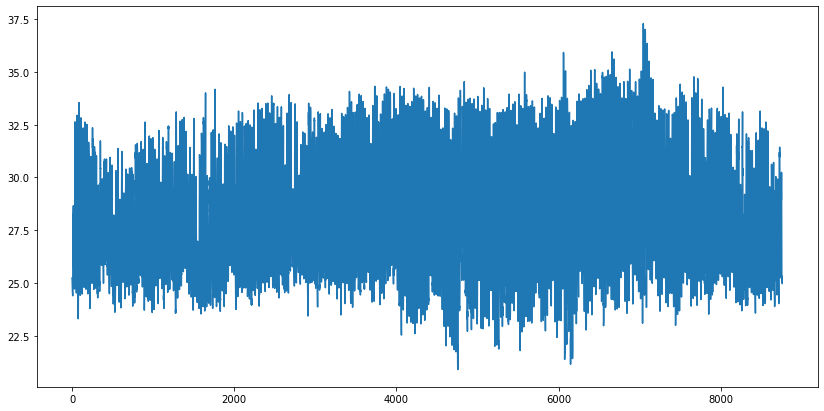

In [ ]:
plt.figure(figsize = (14,7))
plt.plot(range(len(df["JakartaTempratureCelcius"])),df["JakartaTempratureCelcius"])

In [ ]:
dfcelcius = df["JakartaTempratureCelcius"]


dfcelcius

0       25.243750
1       25.183750
2       25.043750
3       24.833750
4       24.733750
          ...    
8755    25.213750
8756    25.333750
8757    25.233748
8758    25.153750
8759    24.983750
Name: JakartaTempratureCelcius, Length: 8760, dtype: float64

In [ ]:
def split_counter(df,split_size):
  training = math.floor(len(df)*split_size)
  testing = math.floor(len(df) - training)

  training_set = df[:training]
  testing_set = df[training:]
  print("We have  {} for training and we have {} for testing".format(training,testing))


  return  training_set,testing_set

training_set, testing_set = split_counter(dfcelcius,0.8)

We have  7008 for training and we have 1752 for testing


In [ ]:
testing_set

7008    25.403748
7009    25.663750
7010    25.723750
7011    24.423750
7012    24.263750
          ...    
8755    25.213750
8756    25.333750
8757    25.233748
8758    25.153750
8759    24.983750
Name: JakartaTempratureCelcius, Length: 1752, dtype: float64

In [ ]:
a = np.array(training_set)


In [ ]:
shuffle_buffer_size = 1000
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(a, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(a.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(7008,)
Epoch 1/100
28/28 [==============================] - 23s 74ms/step - loss: 41.1079 - mae: 41.6060 - lr: 1.0000e-08
Epoch 2/100
28/28 [==============================] - 2s 62ms/step - loss: 31.3387 - mae: 31.8372 - lr: 1.1220e-08
Epoch 3/100
28/28 [==============================] - 2s 62ms/step - loss: 20.4844 - mae: 20.9827 - lr: 1.2589e-08
Epoch 4/100
28/28 [==============================] - 2s 61ms/step - loss: 12.1027 - mae: 12.5993 - lr: 1.4125e-08
Epoch 5/100
28/28 [==============================] - 2s 64ms/step - loss: 5.5714 - mae: 6.0563 - lr: 1.5849e-08
Epoch 6/100
28/28 [==============================] - 2s 64ms/step - loss: 3.7733 - mae: 4.2420 - lr: 1.7783e-08
Epoch 7/100
28/28 [==============================] - 2s 63ms/step - loss: 3.7053 - mae: 4.1725 - lr: 1.9953e-08
Epoch 8/100
28/28 [====================

(1e-08, 0.0001, 0.0, 60.0)

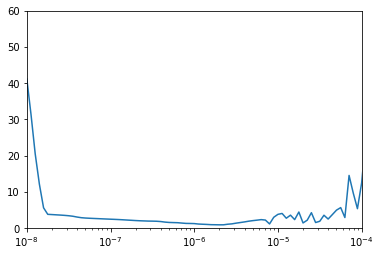

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])



In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(a, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=5e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=600)
                                    

Epoch 1/600
70/70 [==============================] - 7s 36ms/step - loss: 3.5833 - mae: 4.0464
Epoch 2/600
70/70 [==============================] - 3s 36ms/step - loss: 1.2831 - mae: 1.7197
Epoch 3/600
70/70 [==============================] - 3s 36ms/step - loss: 1.1325 - mae: 1.5614
Epoch 4/600
70/70 [==============================] - 3s 36ms/step - loss: 1.6035 - mae: 2.0512
Epoch 5/600
70/70 [==============================] - 3s 36ms/step - loss: 1.1742 - mae: 1.6051
Epoch 6/600
70/70 [==============================] - 3s 37ms/step - loss: 0.9631 - mae: 1.3833
Epoch 7/600
70/70 [==============================] - 3s 37ms/step - loss: 0.8575 - mae: 1.2675
Epoch 8/600
70/70 [==============================] - 3s 37ms/step - loss: 0.8235 - mae: 1.2297
Epoch 9/600
70/70 [==============================] - 3s 36ms/step - loss: 0.8298 - mae: 1.2387
Epoch 10/600
70/70 [==============================] - 3s 37ms/step - loss: 0.7401 - mae: 1.1379
Epoch 11/600
70/70 [=============================

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 60)          360       
                                                                 
 lstm (LSTM)                 (None, None, 64)          32000     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          33024     
                                                                 
 dense (Dense)               (None, None, 30)          1950      
                                                                 
 dense_1 (Dense)             (None, None, 10)          310       
                                                                 
 dense_2 (Dense)             (None, None, 1)           11        
                                                                 
 lambda (Lambda)             (None, None, 1)           0

In [ ]:
datas= np.array(dfcelcius)
datas


array([25.24375   , 25.18375   , 25.04375   , ..., 25.23374778,
       25.15375   , 24.98375   ])

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

rnn_forecast = model_forecast(model, datas[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[(7008 - window_size):-1, -1, 0]
rnn_forecast


array([26.00878 , 25.06672 , 25.297153, ..., 24.530142, 24.800482,
       25.113407], dtype=float32)

In [ ]:
cobacoba2 = np.random.randint(25,35,70)
len(cobacoba2)

70

In [ ]:
rnn_forecast2 = model_forecast(model, cobacoba2[..., np.newaxis], window_size)
rnn_forecast2 = rnn_forecast2[(64 - window_size):-1, -1, 0]
print(rnn_forecast2)

[28.6194   24.905003 28.702332 30.13853  30.50377  28.854137]


In [ ]:
def cvrttolist (listy) : 
  return listy.tolist()
def extenddf(df,forecast):
  a= cvrttolist(df)
  b=cvrttolist(forecast)
  a.extend(b)
  return np.array(a) 
  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

    
def forecasttemprature (df, hour):
  for nexttemprature in range(hour) :
    lstm_forecast2 = model_forecast(Temprature, df[..., np.newaxis], window_size)
    lstm_forecast2 = lstm_forecast2[((len(df)-1) - window_size):-1, -1, 0]
    df=extenddf(df,lstm_forecast2)
  
    lstm_forecast2 = model_forecast(Temprature, df[..., np.newaxis], window_size)
    lstm_forecast2 = lstm_forecast2[((len(df)-1) - window_size):-1, -1, 0]
    df=extenddf(df,lstm_forecast2)

    df=cvrttolist(df)
    a=df[-2]
    df.remove(a)
    df=np.array(df)

  return lstm_forecast2


[26.500103]


array([26.500103], dtype=float32)

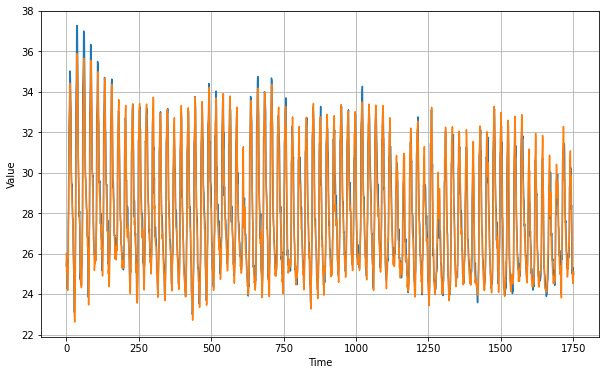

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

plt.figure(figsize=(10, 6))
plot_series(range(len(testing_set)), testing_set)
plot_series(range(len(testing_set)), rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(testing_set, rnn_forecast).numpy()

0.6392796

In [ ]:
#Making dataframe
frames = { "index":list(range(7008,8760)), "Temprature":testing_set, "Temprature-Forcast": rnn_forecast}
dfforcast = pd.DataFrame(frames)
dfforcast["Hour"] = dfforcast["index"]%24
dfforcast

,index,Temprature,Temprature-Forcast,Hour
7008,7008,25.403748,26.008780,0
7009,7009,25.663750,25.066719,1
7010,7010,25.723750,25.297153,2
7011,7011,24.423750,25.248545,3
7012,7012,24.263750,24.242218,4
...,...,...,...,...
8755,8755,25.213750,24.904600,19
8756,8756,25.333750,24.738329,20
8757,8757,25.233748,24.530142,21
8758,8758,25.153750,24.800482,22


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
model.save('saved_model/Temprature')

INFO:tensorflow:Assets written to: saved_model/Temprature/assets


INFO:tensorflow:Assets written to: saved_model/Temprature/assets


In [ ]:
Temprature = tf.keras.models.load_model('/gdrive/MyDrive/saved_model/Temprature')

# Check its architecture
Temprature.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 60)          360       
                                                                 
 lstm (LSTM)                 (None, None, 64)          32000     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          33024     
                                                                 
 dense (Dense)               (None, None, 30)          1950      
                                                                 
 dense_1 (Dense)             (None, None, 10)          310       
                                                                 
 dense_2 (Dense)             (None, None, 1)           11        
                                                                 
 lambda (Lambda)             (None, None, 1)           0